# Classification of Noisy Handwritten Digit Images (MNIST)

This project involves classifying images of handwritten digits from the MNIST dataset. The images represent digits from 0 to 9 and are 28×28 pixel grayscale images. These images have been slightly altered with rotations, shifts, zooms, and variations in lighting. The dataset includes 60,000 images for training and 10,000 images for testing, available in numpy format.

The objective of the project is to develop a model capable of recognizing these handwritten digits. The process involves the following steps:

1. **Data Exploration**: Analysis and visualization of the dataset to understand its structure.
2. **Model Creation**: Building two types of models — fully connected neural network and convolutional neural network.
3. **Model Training**: Training both models on the training dataset.
4. **Model Evaluation**: Evaluating the performance of both models on the test dataset.
5. **Hyperparameter Tuning**: Using Bayesian Search to identify the optimal hyperparameters for each model.
6. **Cross-Validation**: Performing cross-validation to select the best model overall between the two previously selected models.
7. **Final Evaluation**: Testing the best-performing model on the test dataset to assess its final accuracy.

### Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Conv2D, 
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



### Define auxiliary functions

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_loss_accuracy_roc(history, model, x_test, y_test, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title(f'{title} Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title(f'{title} Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')

    # ROC curve plot for each class
    y_val_pred_prob = model.predict(x_test)
    
    # Binarize the labels for one-vs-rest ROC calculation
    n_classes = y_test.shape[1]
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_val_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for each class
        axs[2].plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')
    
    # Plot diagonal line for random guess
    axs[2].plot([0, 1], [0, 1], 'k--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_title(f'{title} ROC Curve')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()


### Load data

In [4]:
# Load the data
x_train = np.load("data/train_images.npy")
y_train = np.load("data/train_labels.npy")
x_test = np.load("data/test_images.npy")
y_test = np.load("data/test_labels.npy")


### Visualize data

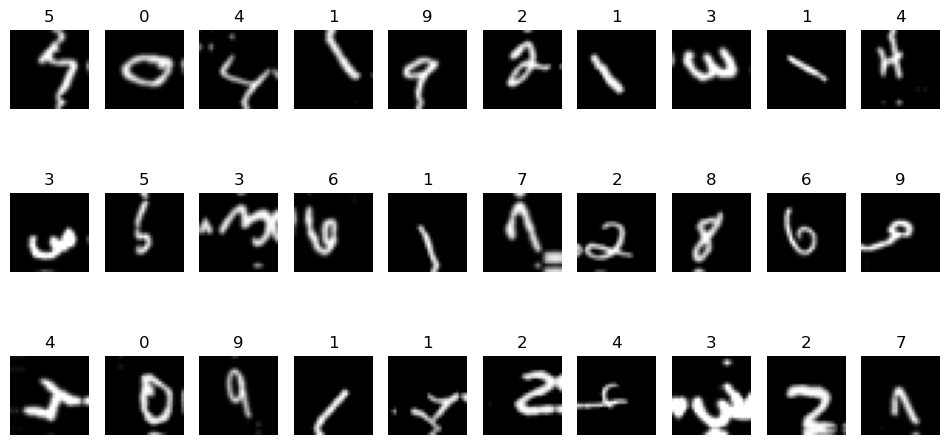

In [5]:
plt.figure(figsize=(12, 6))

for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i], cmap='gray') 
    plt.title(f"{y_train[i]}")
    plt.axis('off') 

plt.show()

### Explore data

In [6]:
print(f'Shape of data X:{x_train.shape}')
print(f'Shape of data Y:{y_train.shape}')
print(f'Shape of data X:{x_test.shape}')
print(f'Shape of data Y:{y_test.shape}')

Shape of data X:(60000, 28, 28, 1)
Shape of data Y:(60000,)
Shape of data X:(10000, 28, 28, 1)
Shape of data Y:(10000,)


In [7]:
print(f"x_train min: {np.min(x_train)}, max: {np.max(x_train)}")
print(f"x_test min: {np.min(x_test)}, max: {np.max(x_test)}")

x_train min: 0.0, max: 1.0
x_test min: 0, max: 255


We can see that train is normalized and test is not.

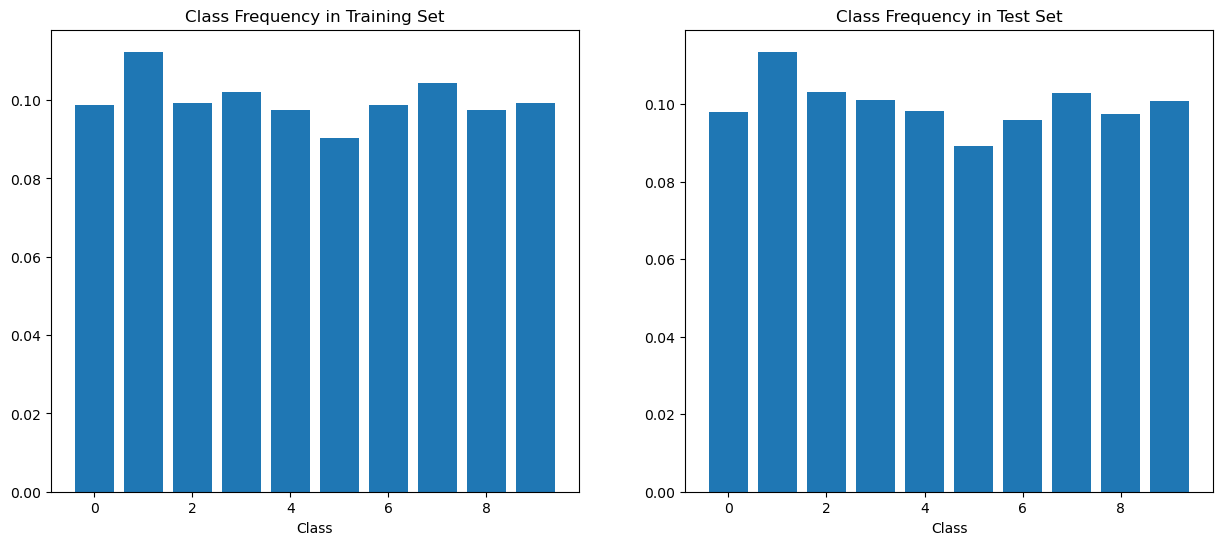

In [8]:
plt.figure(figsize=(15, 6))

unique, counts = np.unique(y_train, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique, counts / len(y_train))
plt.title('Class Frequency in Training Set')
plt.xlabel('Class')

unique, counts = np.unique(y_test, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique, counts / len(y_test))
plt.title('Class Frequency in Test Set')
plt.xlabel('Class')
plt.show()

The classes are more or less balanced and correctly distributed between train and test.

### Preprocess data

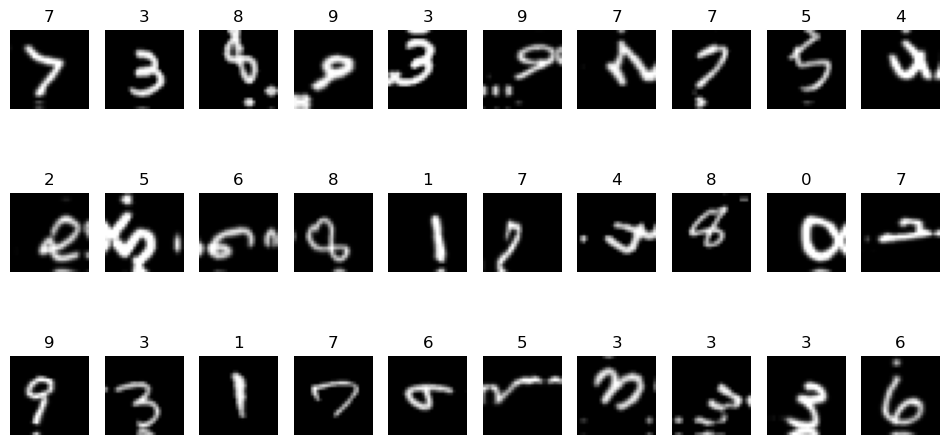

In [9]:
# Normalize the data (train data is already normalized)
x_test = x_test.astype('float32') / 255.0

# Shuffle the x and y data
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

# Visualize the data (verify that everything is correct)
plt.figure(figsize=(12, 6)) 
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i], cmap='gray') 
    plt.title(f"{y_train[i]}")
    plt.axis('off')


In [10]:
# Ensure the correct shape (28x28x1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Verify the shapes
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)
Shape of x_test: (10000, 28, 28, 1)
Shape of y_test: (10000, 10)


### Define the fully connected model

- neuron activation function is a “rectified linear unit”
- output activation function “softmax”
- cost function “cross-entropy”
- two hidden layers with 256 and 128 neurons
- a dropout of 30%
- an optimization method of type rmsprop

In [25]:
def create_dense_model(learning_rate=0.001, neurons_1=256, neurons_2=128, dropout=0.3):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))             # Input for images (28x28, 1 channel)
    model.add(Flatten())                            # Flatten the 2D input into a 1D vector
    model.add(Dense(neurons_1, activation='relu'))  # First dense layer
    model.add(Dropout(dropout))                     # Dropout for regularization
    model.add(Dense(neurons_2, activation='relu'))  # Second dense layer
    model.add(Dense(10, activation='softmax'))      # Output layer for 10 classes
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

dense_model = create_dense_model()
dense_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

### Train the fully connected model

In [26]:
# Add early stopping and model checkpointing
callbacks_dense = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_dense_model.keras', 
                    monitor='val_loss', 
                    save_best_only=True, 
                    verbose=1)
]

In [27]:
# Train the model
history_dense = dense_model.fit(x_train, y_train,
                                epochs=100,
                                batch_size=128,
                                validation_split=0.2,
                                callbacks=callbacks_dense,
                                verbose=1)


Epoch 1/100
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2743 - loss: 2.0212
Epoch 1: val_loss improved from inf to 1.34842, saving model to best_dense_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2749 - loss: 2.0200 - val_accuracy: 0.5664 - val_loss: 1.3484
Epoch 2/100
369/375 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5543 - loss: 1.3284
Epoch 2: val_loss improved from 1.34842 to 1.01469, saving model to best_dense_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5548 - loss: 1.3272 - val_accuracy: 0.6774 - val_loss: 1.0147
Epoch 3/100
367/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6416 - loss: 1.0910
Epoch 3: val_loss improved from 1.01469 to 0.88965, saving model to best_dense_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6417 - loss: 1.0906 - val_accuracy: 0.7248 - val_loss: 0.8897
Epoch 4/100
371/375 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6821 - loss: 0.9739
Epoch 4: val_loss improved from 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


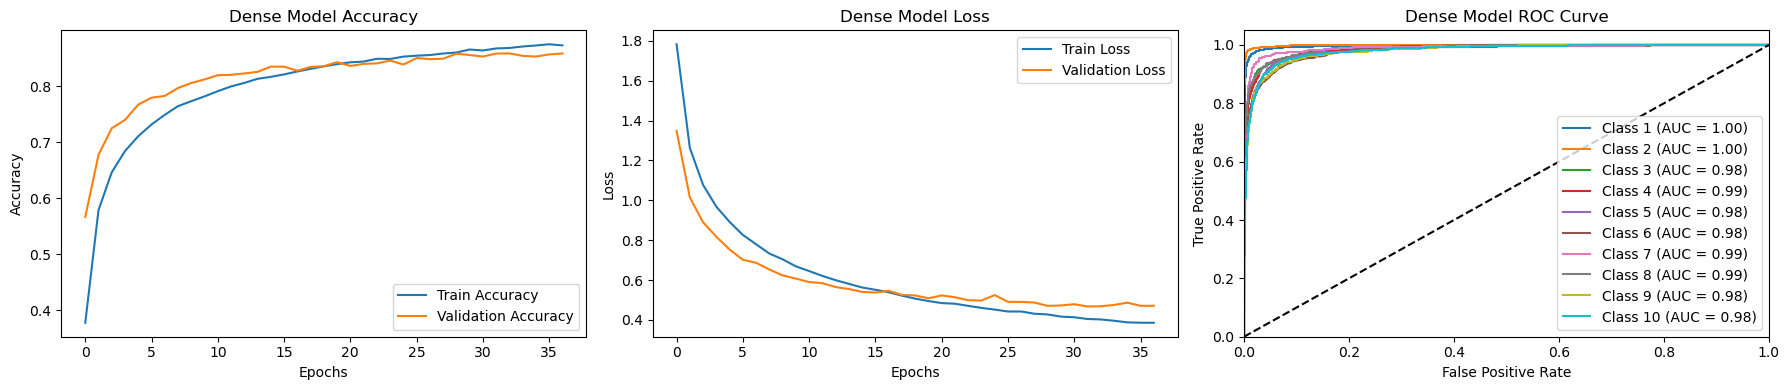

In [30]:
plot_loss_accuracy_roc(history_dense, dense_model, x_test, y_test, 'Dense Model')


The plots of both accuracy and loss are reasonably good. The learning has stopped after 37 epochs and reached an accuracy of 0.86 on the validation set.

### Define the Convolutional Neural Network model

In [11]:
def create_cnn_model(learning_rate=0.0001, nb_conv=2, nb_dense=2, dropout=0.3):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))

    # Convolutional layers
    for i in range(nb_conv):
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        # Apply pooling after every second convolution
        if i % 2 == 1:  
            model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten before fully connected layers
    model.add(Flatten())
    model.add(BatchNormalization())

    # Fully connected layers
    for i in range(nb_dense):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])

    return model

cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 855,658 (3.26 MB)

 Trainable params: 842,986 (3.22 MB)

 Non-trainable params: 12,672 (49.50 KB)

### Train the CNN model

In [32]:
# Add early stopping and model checkpointing
callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_cnn_model.keras', 
                    monitor='val_loss', 
                    save_best_only=True, 
                    verbose=1)
]


In [33]:
# Train model
history_cnn = cnn_model.fit(x_train, y_train,
                            epochs=100,
                            batch_size=128,
                            validation_split=0.2,
                            callbacks=callbacks_cnn,
                            verbose=1)


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2370 - loss: 2.2275
Epoch 1: val_loss improved from inf to 4.90008, saving model to best_cnn_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.2372 - loss: 2.2269 - val_accuracy: 0.1156 - val_loss: 4.9001
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4590 - loss: 1.5606
Epoch 2: val_loss improved from 4.90008 to 1.20959, saving model to best_cnn_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.4591 - loss: 1.5604 - val_accuracy: 0.6092 - val_loss: 1.2096
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5843 - loss: 1.2210
Epoch 3: val_loss improved from 1.20959 to 0.81785, saving model to best_cnn_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.5844 - loss: 1.2209 - val_accuracy: 0.7495 - val_loss: 0.8179
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6641 - loss: 0.9977
Epoch 4: val_loss improved f

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


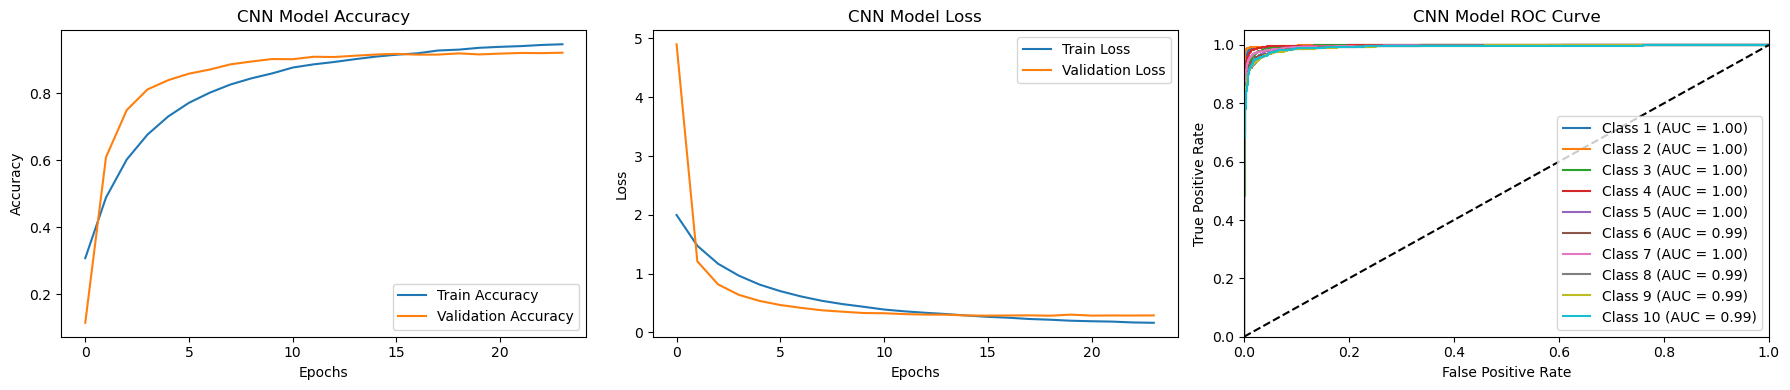

In [34]:
plot_loss_accuracy_roc(history_cnn, cnn_model, x_test, y_test, 'CNN Model')

The model has reached an accuracy of 0.92 on the validation set after 24 epochs. The plots of both accuracy and loss are reasonably good but both are a bit too rapidly decreasing/increasing. The learning rate might be too high or the batch size too small. However, the 0.0001 learning rate is already quite low and the batch size of 128 is already quite large.

### Evaluate models on the test set

In [36]:
# Load the best models
dense_model.load_weights('best_dense_model.keras')
cnn_model.load_weights('best_cnn_model.keras')

dense_test_loss, dense_test_acc = dense_model.evaluate(x_test, y_test, verbose=0)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f"Dense model test accuracy: {dense_test_acc:.4f}")
print(f"CNN model test accuracy: {cnn_test_acc:.4f}")


Dense model test accuracy: 0.8660
CNN model test accuracy: 0.9259


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


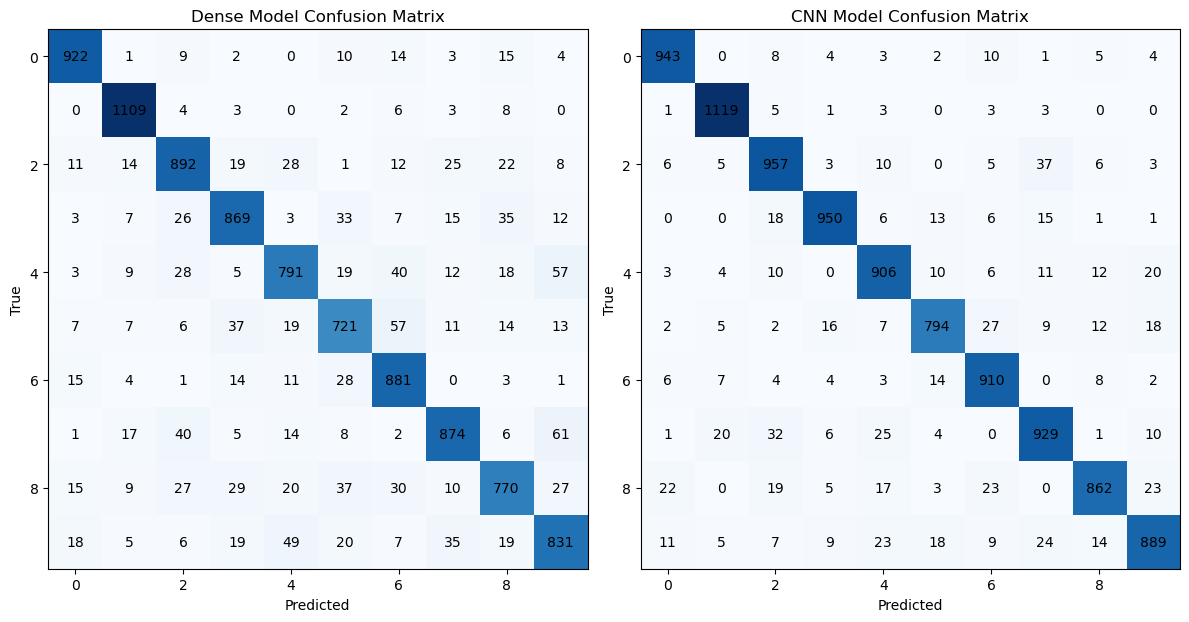

In [37]:
# Predictions for the test set
dense_predictions = dense_model.predict(x_test)
cnn_predictions = cnn_model.predict(x_test)

# Get the predicted classes
dense_predictions = np.argmax(dense_predictions, axis=1)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Get the true classes
true_classes = np.argmax(y_test, axis=1)

# Plot confusion matrices
dense_confusion = pd.crosstab(true_classes, dense_predictions, 
                              rownames=['True'], colnames=['Predicted'])
cnn_confusion = pd.crosstab(true_classes, cnn_predictions, 
                            rownames=['True'], colnames=['Predicted'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Dense model confusion matrix
axs[0].imshow(dense_confusion, cmap='Blues')
axs[0].set_title('Dense Model Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
for i in range(10):
    for j in range(10):
        axs[0].text(j, i, dense_confusion.iloc[i, j], 
                    ha='center', va='center')

# CNN model confusion matrix
axs[1].imshow(cnn_confusion, cmap='Blues')
axs[1].set_title('CNN Model Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
for i in range(10):
    for j in range(10):
        axs[1].text(j, i, cnn_confusion.iloc[i, j], 
                    ha='center', va='center')

plt.tight_layout()
plt.show()

Both models show good performances on the test set. The fully connected model has an accuracy of 0.87 and the CNN model has an accuracy of 0.93. This is an expected result.

### Hyperparameter tuning
The models have reached a good accuracy on the test set but rather modest compared to the original MNIST dataset. This is due to the fact that the images are noisy and the models are not very complex. Now we can perform the hyperparameter tuning to improve the accuracy of the models.

**Bayesian optimization** is a method for hyperparameter tuning that uses probabilistic models to find the best hyperparameters in fewer iterations than traditional search methods like grid or random search. The key idea in Bayesian optimization is that we model the objective function (model accuracy or validation loss) as a probability distribution rather than treating it as a deterministic function.
At each step, Bayesian optimization has to decide where to sample next. It balances two strategies:
- **Exploration**: Trying new hyperparameter combinations that have not been tried yet.
- **Exploitation**: Focusing on areas of the hyperparameter space that have already shown good results (high accuracy or low loss).

In [12]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scikeras.wrappers import KerasClassifier

In [13]:
callbacks = [EarlyStopping(monitor='loss', patience=5, verbose=0)]

In [41]:
# Define model
model = KerasClassifier(model=create_dense_model, verbose=0)

# Define the hyperparameter space
param_space = {
    'batch_size': Integer(32, 128),
    'epochs': Integer(50, 51),
    'model__neurons_1': Integer(128, 256),
    'model__neurons_2': Integer(64, 128),
    'model__dropout': Real(0.1, 0.3),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform')
}

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, 
                             n_iter=32, n_jobs=3, cv=3, scoring='accuracy', 
                             verbose=3, return_train_score=True)

# Train the model
bayes_result = bayes_search.fit(x_train, y_train, callbacks=callbacks)

# Print results
print(f"Best: {bayes_result.best_score_} using {bayes_result.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[CV 1/3] END batch_size=107, epochs=51, model__dropout=0.29949850702398495, model__learning_rate=0.005251026319240124, model__neurons_1=167, model__neurons_2=114;, score=(train=0.889, test=0.797) total time= 1.6min
[CV 3/3] END batch_size=107, epochs=51, model__dropout=0.29949850702398495, model__learning_rate=0.005251026319240124, model__neurons_1=167, model__neurons_2=114;, score=(train=0.885, test=0.791) total time= 1.6min
[CV 2/3] END batch_size=107, epochs=51, model__dropout=0.29949850702398495, model__learning_rate=0.005251026319240124, model__neurons_1=167, model__neurons_2=114;, score=(train=0.887, test=0.789) total time= 1.7min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END batch_size=41, epochs=51, model__dropout=0.1587796312580845, model__learning_rate=0.0019856698787098313, model__neurons_1=181, model__neurons_2=89;, score=(train=0.945, test=0.823) total time= 4.0min
[CV 2/3] END batch_size=41, epochs=51, model__dropout=0.1587796312580845, model__le

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

Finally, the best model has 0.85 accuracy on the test set.
It has:
- batch_size: 128
- epochs: 50
- dropout: 0.3
- learning_rate: 0.0008
- neurons in the first layer: 255
- neurons in the second layer: 128  

So basically the same hyperparameters we used before.

In [15]:
# Define model
model = KerasClassifier(model=create_cnn_model, verbose=0)

# Define the hyperparameter space
param_space = {
    'batch_size': Integer(32, 128),
    'epochs': Integer(50, 51),
    'model__nb_conv': Integer(2, 4),
    'model__nb_dense': Integer(2, 4),
    'model__dropout': Real(0.1, 0.3),
    'model__learning_rate': Real(1e-3, 2e-3, prior='log-uniform')
}

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(estimator=model, 
                             search_spaces=param_space, 
                             n_iter=10,
                             n_jobs=3, 
                             cv=3, 
                             scoring='accuracy', 
                             verbose=3, 
                             return_train_score=True)

# Train the model
bayes_result = bayes_search.fit(x_train, y_train, callbacks=callbacks)

# Print results
print(f"Best: {bayes_result.best_score_} using {bayes_result.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END batch_size=75, epochs=51, model__dropout=0.22837443967257218, model__learning_rate=0.0013947242564209803, model__nb_conv=3, model__nb_dense=3;, score=(train=0.993, test=0.942) total time=127.4min
[CV 1/3] END batch_size=75, epochs=51, model__dropout=0.22837443967257218, model__learning_rate=0.0013947242564209803, model__nb_conv=3, model__nb_dense=3;, score=(train=0.992, test=0.940) total time=127.7min
[CV 2/3] END batch_size=75, epochs=51, model__dropout=0.22837443967257218, model__learning_rate=0.0013947242564209803, model__nb_conv=3, model__nb_dense=3;, score=(train=0.991, test=0.941) total time=128.7min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END batch_size=57, epochs=51, model__dropout=0.24224691537152207, model__learning_rate=0.0012058741157026855, model__nb_conv=3, model__nb_dense=3;, score=(train=0.983, test=0.933) total time=66.7min
[CV 2/3] END batch_size=57, epochs=51, model__d

### Cross-validation to select the best model

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from scipy.stats import wilcoxon
from joblib import Parallel, delayed
from tqdm import tqdm

In [14]:
def train_and_evaluate_fold(model, X_train, y_train, 
                            X_test, y_label, callbacks):
    """Train and evaluate the model on a given fold."""
    model.fit(X_train, y_train, epochs=50, callbacks=callbacks, verbose=0)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    acc = accuracy_score(y_label, y_pred)
    return acc

def cross_validate_models(model1, model2, X, y, k=5, n_jobs=-1):
    """Cross-validate two models and perform a Wilcoxon signed-rank test."""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    model1_scores = Parallel(n_jobs=n_jobs)(
        delayed(train_and_evaluate_fold)(
            model1, X[train_idx], y[train_idx], X[test_idx], 
            np.argmax(y[test_idx], axis=1), callbacks
        ) for train_idx, test_idx in tqdm(kf.split(X))
    )

    model2_scores = Parallel(n_jobs=n_jobs)(
        delayed(train_and_evaluate_fold)(
            model2, X[train_idx], y[train_idx], X[test_idx], 
            np.argmax(y[test_idx], axis=1), callbacks
        ) for train_idx, test_idx in tqdm(kf.split(X))
    )

    # Convert lists to numpy arrays for easier manipulation
    model1_scores = np.array(model1_scores)
    model2_scores = np.array(model2_scores)

    # Perform Wilcoxon signed-rank test
    stat, p_value = wilcoxon(model1_scores, model2_scores)

    mean_accuracy_model1 = np.mean(model1_scores)
    mean_accuracy_model2 = np.mean(model2_scores)

    return mean_accuracy_model1, mean_accuracy_model2, p_value



In [16]:
best_model_fc = create_dense_model(neurons_1=256, neurons_2=128, 
                                   dropout=0.3, learning_rate=0.001)
best_model_cnn = create_cnn_model(nb_conv=4, nb_dense=4, 
                                  dropout=0.1, learning_rate=0.001)

mean_acc_fc, mean_acc_cnn, p_val = cross_validate_models(
    best_model_fc, best_model_cnn, x_train, y_train, k=5, n_jobs=2
)

print(f"Mean Accuracy (Fully Connected): {mean_acc_fc:.4f}")
print(f"Mean Accuracy (CNN): {mean_acc_cnn:.4f}")
print(f"P-value from Wilcoxon test: {p_val:.4f}")

if p_val < 0.05:
    print("The difference in model performance is statistically significant.")
else:
    print("No significant difference between the models' performance.")


2it [00:00, 12.09it/s]/home/nadia/miniconda3/envs/deep-learning/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/nadia/miniconda3/envs/deep-learning/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
4it [06:16, 110.74s/it]/home/nadia/miniconda3/envs/deep-learning/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
5it [06:16, 75.39s/it] 
/home/nadia/minicon

Mean Accuracy (Fully Connected): 0.8483
Mean Accuracy (CNN): 0.9450
P-value from Wilcoxon test: 0.0625
No significant difference between the models' performance.
